<div style="font-size: 3em; font-weight: bold; padding-bottom: 0.3em">Exercise: UNIX, HDFS and MapReduce</div>

In this exercise the Yelp data files are referenced through symbolic links to the actual files
<pre>
business.json -> /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json
checkin.json -> /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json
review.json -> /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json
tip.json -> /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_tip.json
user.json -> /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json
</pre>

In [125]:
%%sh
for F in /home/data/yelp/yelp_dataset_challenge_academic_dataset/*.json; do 
    ln -s $F `basename $F| cut -d_ -f4`
done

The following are ideas to test our newly gained knowledge:

# Warm-up
2. Extract CSV tables from Yelp or Twitter JSON files using `jq` or `python`.
3. Perform aggregations and frequency counts using UNIX command line tools and pipes.
1. Create a folder structure under your user directory on the HDFS, and load some data files (e.g. Yelp) from the local file-system. Split data- files into smaller chunks, and `gzip` them.

## Extract CSV tables from Yelp JSON files using `jq` or `python`.
`jq` is a neat command line tool for extracting JSON data. Information on how to use `jq` can be found at https://stedolan.github.io/jq/tutorial/.

Let's "flatten" the `business.json` file to a CSV table with the fields
1. business_id
2. name
4. city
5. state


In [53]:
%%sh
head business.json | jq -j '.business_id, ",", .type, ",", .name, ",", .city, ",", .state, "\n"'

5UmKMjUEUNdYWqANhGckJw,business,Mr Hoagie,Dravosburg,PA
UsFtqoBl7naz8AVUBZMjQQ,business,Clancy's Pub,Dravosburg,PA
cE27W9VPgO88Qxe4ol6y_g,business,Cool Springs Golf Center,Bethel Park,PA
mVHrayjG3uZ_RLHkLj-AMg,business,Emil's Lounge,Braddock,PA
mYSpR_SLPgUVymYOvTQd_Q,business,Grand View Golf Club,Braddock,PA
KayYbHCt-RkbGcPdGOThNg,business,Alexion's Bar & Grill,Carnegie,PA
b12U9TFESStdy7CsTtcOeg,business,Flynn's Tire & Auto Service,Carnegie,PA
Sktj1eHQFuVa-M4bgnEh8g,business,Forsythe Miniature Golf & Snacks,Carnegie,PA
3ZVKmuK2l7uXPE6lXY4Dbg,business,Quaker State Construction,Carnegie,PA
QoDa50dc7g62xciFygXB9w,business,Greentree Animal Clinic,Pittsburgh,PA


There's so much more to `jq` ... though let's move on to Python

In [54]:
import sys
import json
with open('business.json') as stream:
    max_records = 10
    for line in stream.readlines():
        r = json.loads(line.strip())
        print ','.join([r['business_id'], r['type'], r['name'], r['city'], r['state']]) 
        max_records -= 1
        if max_records < 0:
            break
            

5UmKMjUEUNdYWqANhGckJw,business,Mr Hoagie,Dravosburg,PA
UsFtqoBl7naz8AVUBZMjQQ,business,Clancy's Pub,Dravosburg,PA
cE27W9VPgO88Qxe4ol6y_g,business,Cool Springs Golf Center,Bethel Park,PA
mVHrayjG3uZ_RLHkLj-AMg,business,Emil's Lounge,Braddock,PA
mYSpR_SLPgUVymYOvTQd_Q,business,Grand View Golf Club,Braddock,PA
KayYbHCt-RkbGcPdGOThNg,business,Alexion's Bar & Grill,Carnegie,PA
b12U9TFESStdy7CsTtcOeg,business,Flynn's Tire & Auto Service,Carnegie,PA
Sktj1eHQFuVa-M4bgnEh8g,business,Forsythe Miniature Golf & Snacks,Carnegie,PA
3ZVKmuK2l7uXPE6lXY4Dbg,business,Quaker State Construction,Carnegie,PA
QoDa50dc7g62xciFygXB9w,business,Greentree Animal Clinic,Pittsburgh,PA
1_lU0-eSWJCRvNGk78Zh9Q,business,Carnegie Free Library,Carnegie,PA


The `json.loads()` function take a string of JSON encoded data and converts it into a Python dictionary `dict` that has the same (nested) structure as the JSON record.

Beware that using a non-existing key on the dictionary will cause an exception. Therefore, one should
1. either test if the key exists `if "name" in r.keys():`, or
2. use a `try...except` block

Python also offers more opportunities to manipulate out data fields. E.g. the `full_address` field contains new-line characters. We can replaces them with something else, like `^`.

Let's put a header in, too...though usually we don't use headers in large data projects because we like to be able to split and combine files.

In [55]:
import sys
import json

# header...usually we don't use them
print 'business_id,type,name,full_address,city,state'

with open('business.json') as stream:
    max_records = 10
    for line in stream.readlines():
        try:
            r = json.loads(line.strip())
            print ','.join([r['business_id'], r['type'], r['name'], r['full_address'].replace('\n', '^'), r['city'], r['state']]) 
            max_records -= 1
            if max_records < 0:
                break
        except:
            None  ### we don't produce an output row

business_id,type,name,full_address,city,state
5UmKMjUEUNdYWqANhGckJw,business,Mr Hoagie,4734 Lebanon Church Rd^Dravosburg, PA 15034,Dravosburg,PA
UsFtqoBl7naz8AVUBZMjQQ,business,Clancy's Pub,202 McClure St^Dravosburg, PA 15034,Dravosburg,PA
cE27W9VPgO88Qxe4ol6y_g,business,Cool Springs Golf Center,1530 Hamilton Rd^Bethel Park, PA 15234,Bethel Park,PA
mVHrayjG3uZ_RLHkLj-AMg,business,Emil's Lounge,414 Hawkins Ave^Braddock, PA 15104,Braddock,PA
mYSpR_SLPgUVymYOvTQd_Q,business,Grand View Golf Club,1000 Clubhouse Dr^Braddock, PA 15104,Braddock,PA
KayYbHCt-RkbGcPdGOThNg,business,Alexion's Bar & Grill,141 Hawthorne St^Greentree^Carnegie, PA 15106,Carnegie,PA
b12U9TFESStdy7CsTtcOeg,business,Flynn's Tire & Auto Service,718A Hope Hollow Rd^Carnegie, PA 15106,Carnegie,PA
Sktj1eHQFuVa-M4bgnEh8g,business,Forsythe Miniature Golf & Snacks,920 Forsythe Rd^Carnegie^Carnegie, PA 15106,Carnegie,PA
3ZVKmuK2l7uXPE6lXY4Dbg,business,Quaker State Construction,8 Logan St^Carnegie^Carnegie, PA 15106,Carnegie,PA


Let's use this code in a script that can run like a UNIX command. Reading from Standard Input, processing data, and then sending results to Standard Output is an elegant and flexible way.

The following code is stored in a script `business_mpr.py`. Instead from opening a specific file we read from `sys.stdin`

In [56]:
%%sh
cat business_mpr.py
chmod a+x business_mpr.py
ls -l business_mpr.py

#!/usr/bin/python

import sys
import json

for line in sys.stdin.readlines():
    try:
        r = json.loads(line.strip())
        print ','.join([r['business_id'], r['type'], r['name'], r['full_address'].replace('\n', '^'), r['city'], r['state']]) 
    except:
        None  ### we don't produce an output row
-rwxr-xr-x 1 pmolnar pmolnar 312 Jan 14 20:33 business_mpr.py


Let's try it out

In [57]:
%%sh
head business.json | ./business_mpr.py

5UmKMjUEUNdYWqANhGckJw,business,Mr Hoagie,4734 Lebanon Church Rd^Dravosburg, PA 15034,Dravosburg,PA
UsFtqoBl7naz8AVUBZMjQQ,business,Clancy's Pub,202 McClure St^Dravosburg, PA 15034,Dravosburg,PA
cE27W9VPgO88Qxe4ol6y_g,business,Cool Springs Golf Center,1530 Hamilton Rd^Bethel Park, PA 15234,Bethel Park,PA
mVHrayjG3uZ_RLHkLj-AMg,business,Emil's Lounge,414 Hawkins Ave^Braddock, PA 15104,Braddock,PA
mYSpR_SLPgUVymYOvTQd_Q,business,Grand View Golf Club,1000 Clubhouse Dr^Braddock, PA 15104,Braddock,PA
KayYbHCt-RkbGcPdGOThNg,business,Alexion's Bar & Grill,141 Hawthorne St^Greentree^Carnegie, PA 15106,Carnegie,PA
b12U9TFESStdy7CsTtcOeg,business,Flynn's Tire & Auto Service,718A Hope Hollow Rd^Carnegie, PA 15106,Carnegie,PA
Sktj1eHQFuVa-M4bgnEh8g,business,Forsythe Miniature Golf & Snacks,920 Forsythe Rd^Carnegie^Carnegie, PA 15106,Carnegie,PA
3ZVKmuK2l7uXPE6lXY4Dbg,business,Quaker State Construction,8 Logan St^Carnegie^Carnegie, PA 15106,Carnegie,PA
QoDa50dc7g62xciFygXB9w,business,Greentree Anim

## Simple Analysis: how many restaurants per city (state)?
Perform aggregations and frequency counts using **UNIX command line tools** and pipes. Well, our `business_mpr.py` is a command line tool, too.

Let's list the top 10 cities with most businesses:

In [64]:
%%sh
cat business.json | ./business_mpr.py | cut -d, -f6,7 | sort | uniq -c | sort -rn | head

  18501 Las Vegas,NV
  11504 Phoenix,AZ
   5550 Charlotte,NC
   5297 Scottsdale,AZ
   3544 Pittsburgh,PA
   3532 Mesa,AZ
   3256 EDH
   2983 Henderson,NV
   2956 Tempe,AZ
   2603 Chandler,AZ


sort: write failed: standard output: Broken pipe
sort: write error


What kind of business to we have in the data? This is a quick way to extract all levels of a field from large data files. Here, we take the second field `-f2` from a comma separated `-d,` stream. 

In [65]:
cat business.json | ./business_mpr.py | cut -d, -f2 | sort | uniq -c | sort -rn | head

  80670 business


How disappointing...Well, let's look what's going on in Nevada

In [72]:
%%sh
cat business.json | ./business_mpr.py | cut -d, -f6,7 | grep ',NV' | sort | uniq -c | sort -rn | head

  18501 Las Vegas,NV
   2983 Henderson,NV
    928 North Las Vegas,NV
     42 Boulder City,NV
     25 Paradise,NV
     19 N Las Vegas,NV
     14 Nellis AFB,NV
      6 Spring Valley,NV
      6 Las Vegas ,NV
      6 Enterprise,NV


In addition to our Python script we only need regular UNIX commands
- `cat` loads one or more files and puts the data into STDOUT
- `cut` reads lines, splits them into fields by the given delimiter `-d,` and produces lines with only certain fields `-f6,7`
- `grep` filters lines by a given string or pattern
- `sort` is capable of sorting very large text-files (or streams) by row. Usually in lexicographical order, but also numeric `-n`, and the order can be reversed `-r`
- `uniq` eliminates duplicate lines if they follow in succession. With `-c` it also counts duplicates
- `head` cuts the stream of after a given number of lines (10 by default). There's also a `tail`

How many levels does each field in our data set have? This might be useful to identify features for machine learning.

In [73]:
%%sh
for N in {1..7}; do
    echo -n "Field $N: "
    cat business.json | ./business_mpr.py | cut -d, -f$N | sort | uniq | wc -l
done

Field 1: 80670
Field 2: 1
Field 3: 59903
Field 4: 66209
Field 5: 3706
Field 6: 847
Field 7: 202


In [77]:
%%sh
echo "The 'business.json' file has `wc -l < business.json` records."
echo "However, `cat business.json | ./business_mpr.py | wc -l` valid records are actually extracted by the mapper."

The 'business.json' file has 85901 records.
However, 80670 valid records are actually extracted by the mapper.


A few simple UNIX commands can give us a quick peek into the data...even if they are too large to fit into Pandas or R data frames.
`wc` counts characters, words, and lines. `wc -l` only returns the number of lines.

## Load data to HDFS
MapReduce and other members of the Hadoop family operate on the Hadoop File System. When given a name or path to data files they usually expect them to be present on HDFS. Programs and libraries are stored on the local file system.

There are several commands that allow us to deal with files on HDFS, and shuffle data back and forth. On our system the commands 'hadoop fs' and 'hdfs dfs' do the same thing, but behave differently on other installations. http://stackoverflow.com/questions/18142960/whats-the-difference-between-hadoop-fs-shell-commands-and-hdfs-dfs-shell-co

In [80]:
%%sh
echo "Hello $USER! This is your personal directory on HDFS"
hdfs dfs -ls /user/$USER

Hello pmolnar! This is your personal directory on HDFS
Found 8 items
drwx------   - pmolnar hadoop          0 2016-10-02 20:00 /user/pmolnar/.Trash
drwxr-xr-x   - pmolnar hadoop          0 2016-09-05 16:59 /user/pmolnar/.hiveJars
drwxr-xr-x   - pmolnar hadoop          0 2016-11-21 17:29 /user/pmolnar/.sparkStaging
drwx------   - pmolnar hadoop          0 2017-01-14 11:53 /user/pmolnar/.staging
drwxr-xr-x   - pmolnar hadoop          0 2017-01-14 11:04 /user/pmolnar/data
-rw-r--r--   3 pmolnar hadoop     147225 2017-01-13 15:51 /user/pmolnar/debellocallico.txt
drwxr-xr-x   - pmolnar hadoop          0 2016-10-23 19:18 /user/pmolnar/first-mr-output
drwxr-xr-x   - pmolnar hadoop          0 2017-01-14 11:52 /user/pmolnar/output


In [81]:
%%sh
hdfs dfs -help | head ### "| head" to see the complete documentation

Usage: hadoop fs [generic options]
	[-appendToFile <localsrc> ... <dst>]
	[-cat [-ignoreCrc] <src> ...]
	[-checksum <src> ...]
	[-chgrp [-R] GROUP PATH...]
	[-chmod [-R] <MODE[,MODE]... | OCTALMODE> PATH...]
	[-chown [-R] [OWNER][:[GROUP]] PATH...]
	[-copyFromLocal [-f] [-p] [-l] <localsrc> ... <dst>]
	[-copyToLocal [-p] [-ignoreCrc] [-crc] <src> ... <localdst>]
	[-count [-q] [-h] [-v] [-t [<storage type>]] <path> ...]


Let's create a directory for our data on HDFS. Then copy the data files into the new directory 

In [92]:
%%sh
hdfs dfs -mkdir -p /user/$USER/yelp/data
for F in /home/data/yelp/yelp_dataset_challenge_academic_dataset/*.json; do
    echo "Copying $F"
    hdfs dfs -put $F /user/$USER/yelp/data/
done

Copying /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json
Copying /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json
Copying /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json
Copying /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_tip.json
Copying /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json


Usually data files are very large and need to be read by multiple workers at the same time. We, therefore, split our data files into chunks...roughly into the number of workers we may use. For these files creating 10 chunks might be sufficient. 
In addition we compress our chunks with `gzip`. All Hadoop members can unzip on the fly...so do Pandas and R.

How many records do we have in each file?

In [94]:
%%sh
for F in /home/data/yelp/yelp_dataset_challenge_academic_dataset/*.json; do
   wc -l $F
done

85901 /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json
61049 /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_checkin.json
2685066 /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json
648902 /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_tip.json
686556 /home/data/yelp/yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_user.json


The UNIX command `split` takes care of it. The following example uses a few other commands to get our data in the shape we want them.
This also include computing the proper number of lines for each chunk.

In [ ]:
%%sh
for F in /home/data/yelp/yelp_dataset_challenge_academic_dataset/*.json; do
    N=`basename $F .json | cut -d_ -f4`
    L=$((`wc -l < $F`/10))
    echo "File '$F' split in chunks of $L lines into folders named '$N'"
    FILTER='gzip > $FILE.json.gz; hdfs dfs -put $FILE.json.gz /user/'$USER'/yelp/data/'$N'/; rm $FILE.json.gz'
    hdfs dfs -mkdir -p /user/$USER/yelp/data/$N
    split --lines=$L --filter="'$FILTER'" $F ${N}_ 
done

In most cases data files won't be available on the local file system. Rather, there are some processes that load them from other servers, such as SQL databases or sources on the web. In those cases we would follow a similar process:
1. read a number of records into a temporary file
2. zip and load onto HDFS

# Walk
1. Write a Map-Reduce mapper to filter and convert rows from a single datafile, and produce a (small) CSV table. Run Map-Reduce with data on the HDFS, move the resulting CSV table onto the local file system.
2. Write a mapper and reducer to count words in Yelp reviews. Produce a list with the 200 most frequent words.
1. Let's do some MapReduce
1. Join tables using MapReduce (use Yelp ... and incorporate JSON extraction)

## MapReduce
Let's find the cities with the most businesses...again.
The way we did it with UNIX commands (and our scripts) was to extract the **key** value, City/State, order the records by this key, and then count the records that have the same key value.

`cat business.json | ./business_mpr.py | cut -d, -f6,7 | sort | uniq -c | sort -rn | head`

MapReduce works pretty much the same way as the pipeline above whereby certain tasks are handled by the system
1. the system takes care of feeding data (`cat business.json `)
2. our mapper needs to digest the records and produce output with the key value as the first element 
    (`./business_mpr.py | cut -d, -f6,7`)
3. the system will sort and shuffle (`sort`)
4. our mapper counts the records with the same key value (`uniq -c`)
5. the system collects results in specified output files


First we refine the mapper. The following code should be saved in `business_city_mpr.py`.
We can test it out right away. 

In [ ]:
#!/usr/bin/python

import sys
import json

for line in sys.stdin.readlines():
    try:
        r = json.loads(line.strip())
        print r['city']+"/"+r['state'] 
    except:
        None  ### we don't produce an output row

In [127]:
%%sh
chmod a+x business_city_mpr.py
cat business.json | ./business_city_mpr.py | sort | uniq -c | head

      1 110 Las Vegas/NV
      1 Ahwahtukee/AZ
     12 Ahwatukee/AZ
      1 Ahwatukee Foothills Village/AZ
      1 Allegheny/PA
      2 Allentown/PA
     11 Anjou/QC
    135 Anthem/AZ
    186 Apache Junction/AZ
      2 Arlington/AZ


uniq: write error: Broken pipe


Let's run it as MapReduce job

In [130]:
%%sh
# use the current directory as location for program files
WD=`pwd`

OUTDIR=/user/$USER/yelp/output
OUTPUT=$OUTDIR/business_by_city

# make sure output directory exists
hdfs dfs -mkdir -p $OUTDIR 

# make sure the output files don't exist
hdfs dfs -rm -r -f -skipTrash $OUTPUT

INPUT=/user/$USER/yelp/data/business/*
yarn \
    jar /usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar \
    -mapper "$WD/business_city_mpr.py" \
    -reducer "/usr/bin/uniq -c" \
    -input $INPUT \
    -output $OUTPUT

Deleted /user/pmolnar/yelp/output/business_by_city
packageJobJar: [] [/usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar] /var/lib/ambari-agent/tmp/hadoop_java_io_tmpdir/streamjob2401020890362579846.jar tmpDir=null


17/01/15 14:35:39 INFO impl.TimelineClientImpl: Timeline service address: http://backend-0-2.insight.gsu.edu:8188/ws/v1/timeline/
17/01/15 14:35:39 INFO client.RMProxy: Connecting to ResourceManager at backend-0-1.insight.gsu.edu/192.168.1.253:8050
17/01/15 14:35:40 INFO impl.TimelineClientImpl: Timeline service address: http://backend-0-2.insight.gsu.edu:8188/ws/v1/timeline/
17/01/15 14:35:40 INFO client.RMProxy: Connecting to ResourceManager at backend-0-1.insight.gsu.edu/192.168.1.253:8050
17/01/15 14:35:40 INFO mapred.FileInputFormat: Total input paths to process : 11
17/01/15 14:35:40 INFO mapreduce.JobSubmitter: number of splits:11
17/01/15 14:35:40 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1483712992215_0013
17/01/15 14:35:41 INFO impl.YarnClientImpl: Submitted application application_1483712992215_0013
17/01/15 14:35:41 INFO mapreduce.Job: The url to track the job: http://backend-0-1.insight.gsu.edu:8088/proxy/application_1483712992215_0013/
17/01/15 14:35:41 

That's a long output. Looks like everything went well. Let's see what we got:

In [132]:
%%sh
OUTDIR=/user/$USER/yelp/output
OUTPUT=$OUTDIR/business_by_city
sh hdfs dfs -ls $OUTPUT

Found 2 items
-rw-r--r--   3 pmolnar hadoop          0 2017-01-15 14:35 /user/pmolnar/yelp/output/business_by_city/_SUCCESS
-rw-r--r--   3 pmolnar hadoop      10636 2017-01-15 14:35 /user/pmolnar/yelp/output/business_by_city/part-00000


In [135]:
%%sh
OUTDIR=/user/$USER/yelp/output
OUTPUT=$OUTDIR/business_by_city
sh hdfs dfs -cat $OUTPUT/part-00000 | sort -rn | head 

  19326 Las Vegas/NV	
  11851 Phoenix/AZ	
   5694 Charlotte/NC	
   5638 Scottsdale/AZ	
   3637 Mesa/AZ	
   3627 Pittsburgh/PA	
   3224 Edinburgh/EDH	
   3145 Henderson/NV	
   3043 Tempe/AZ	
   2701 Chandler/AZ	


sort: write failed: standard output: Broken pipe
sort: write error


## Join 'business' set with 'checkin' set
The checkin set holds a distribution of patrons per hour per day per week. If we want to know the typical dining hours per city, we need to join the set to the busniness set. Then aggregate over the city.

###  Mapper
The mappers job is to produce records with leading key values so that we can bring records of both sets together. We can pass the entire records along for the reducer.

In [ ]:
#!/usr/bin/python
### checkin_mpr.py produces recrods with leading business_id
import sys
import json

for line in sys.stdin:
    try:
        r = json.loads(line.strip())
        print r['business_id']+"\t"+line.strip() 
    except:
        None  ### we don't produce an output row

In [138]:
%%sh
chmod a+x checkin_mpr.py
(head business.json; head checkin.json) | ./checkin_mpr.py | sort | head

1_lU0-eSWJCRvNGk78Zh9Q	{"checkin_info": {"11-6": 1, "18-4": 1, "15-4": 1, "10-6": 1, "10-5": 1}, "type": "checkin", "business_id": "1_lU0-eSWJCRvNGk78Zh9Q"}
3ZVKmuK2l7uXPE6lXY4Dbg	{"business_id": "3ZVKmuK2l7uXPE6lXY4Dbg", "full_address": "8 Logan St\nCarnegie\nCarnegie, PA 15106", "hours": {}, "open": true, "categories": ["Roofing", "Home Services", "Decks & Railing", "Contractors"], "city": "Carnegie", "review_count": 3, "name": "Quaker State Construction", "neighborhoods": ["Carnegie"], "longitude": -80.0903905, "state": "PA", "stars": 2.5, "latitude": 40.4062805, "attributes": {}, "type": "business"}
5UmKMjUEUNdYWqANhGckJw	{"business_id": "5UmKMjUEUNdYWqANhGckJw", "full_address": "4734 Lebanon Church Rd\nDravosburg, PA 15034", "hours": {"Friday": {"close": "21:00", "open": "11:00"}, "Tuesday": {"close": "21:00", "open": "11:00"}, "Thursday": {"close": "21:00", "open": "11:00"}, "Wednesday": {"close": "21:00", "open": "11:00"}, "Monday": {"close": "21:00", "open": "11:00"}}, "open": 

### Reducer
The reducer has more work to do. All the reduce can count on is that
- all records with the same key will be delivered to the same reducer
- all records with the same key are together in the stream

Still the reducer must
- identify the origin of the record since we load two data sets
- aggregate within the group.

In [ ]:
# %load checkin_join_reducer.py
#!/usr/bin/python
### checkin_join_reducer.py

## This reducer joins two data sets (business.json and checkin.json) on their business_id
import sys
import json
import numpy as np

current_bid = None
bid = None
reco = None

business_list = []
checkin_list = []

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    bid, rjson = line.split('\t', 1)

    if current_bid == bid:
        if '"type": "checkin"' in rjson:
            checkin_list.append(rjson)
        else:
            business_list.append(rjson)
        
    else:
        if current_bid:
            for b in business_list:
                for c in checkin_list:
                    print '%s\t%s\t%s' % (current_bid, b.strip(), c.strip())
        current_bid = bid
        business_list = []
        checkin_list = []
        if '"type": "checkin"' in rjson:
            checkin_list.append(rjson)
        else:
            business_list.append(rjson)

# do not forget to output the last word if needed!
if current_bid == bid:
    for b in business_list:
        for c in checkin_list:
            print '%s\t%s\t%s' % (current_bid, b.strip(), c.strip())
            


This reducer collects all records with the same business_id from both sets and produces all combinations of both sets. This is equivalent to an **inner join**. In order to create a **left outer join** one could also emit business records without any matching checkin records.

In [170]:
%%sh
chmod a+x ./checkin_join_reducer.py
cat business.json checkin.json | ./checkin_mpr.py | sort | ./checkin_join_reducer.py | head -3

000i-lkjp-wsnk5s6z3s2Q	{"business_id": "000i-lkjp-wsnk5s6z3s2Q", "full_address": "7501 N Cimarron Rd\nCentennial\nLas Vegas, NV 89131", "hours": {"Monday": {"close": "19:00", "open": "09:30"}, "Tuesday": {"close": "19:00", "open": "09:30"}, "Friday": {"close": "19:00", "open": "09:30"}, "Wednesday": {"close": "19:00", "open": "09:30"}, "Thursday": {"close": "19:00", "open": "09:30"}, "Sunday": {"close": "17:00", "open": "10:00"}, "Saturday": {"close": "19:00", "open": "09:30"}}, "open": true, "categories": ["Beauty & Spas", "Nail Salons"], "city": "Las Vegas", "review_count": 29, "name": "Orchid Nail Spa", "neighborhoods": ["Centennial"], "longitude": -115.270268, "state": "NV", "stars": 4.0, "latitude": 36.29733, "attributes": {"By Appointment Only": false, "Parking": {"garage": false, "street": false, "validated": false, "lot": true, "valet": false}, "Accepts Credit Cards": true, "Price Range": 2}, "type": "business"}	{"checkin_info": {"18-0": 1, "9-5": 1, "10-0": 1, "18-1": 2, "20-0

Traceback (most recent call last):
  File "./checkin_join_reducer.py", line 34, in <module>
    print '%s\t%s\t%s' % (current_bid, b.strip(), c.strip())
IOError: [Errno 32] Broken pipe
sort: write failed: standard output: Broken pipe
sort: write error


We now have the city and state data linked to every checkin record. In a second step we can aggregate the check-in hours by city.

The mapper:

In [ ]:
# %load checkin_by_city_mpr.py
#!/usr/bin/python
# get data in the format business_id {business.json} {checkin.json}
# produce records with city/state key

import sys
import json

for line in sys.stdin:
    line = line.strip()
    try:
        bid, bjson, cjson = line.split('\t')
        brec = json.loads(bjson)
        print "%s/%s\t%s" % (brec['city'].strip(), brec['state'].strip(), cjson)
    except:
        None
        


In [179]:
%%sh
chmod a+x checkin_by_city_mpr.py
cat business.json checkin.json | ./checkin_mpr.py | sort | ./checkin_join_reducer.py | ./checkin_by_city_mpr.py | head -3

Las Vegas/NV	{"checkin_info": {"18-0": 1, "9-5": 1, "10-0": 1, "18-1": 2, "20-0": 1, "13-4": 1, "14-6": 1, "15-4": 2, "15-6": 1, "11-5": 1, "17-6": 1, "18-3": 1, "23-6": 1, "16-4": 1, "17-0": 1, "14-4": 1, "14-5": 1, "12-4": 1, "10-4": 2, "14-1": 1, "19-4": 1}, "type": "checkin", "business_id": "000i-lkjp-wsnk5s6z3s2Q"}
Las Vegas/NV	{"checkin_info": {"22-5": 6, "22-4": 2, "22-3": 5, "22-1": 3, "22-0": 3, "19-5": 24, "19-4": 14, "19-6": 13, "19-1": 9, "19-0": 6, "19-3": 9, "19-2": 3, "11-5": 5, "11-4": 1, "11-6": 3, "11-2": 2, "12-6": 2, "12-4": 2, "12-5": 3, "12-2": 1, "12-3": 1, "12-0": 2, "16-2": 6, "16-3": 12, "16-1": 9, "16-6": 5, "16-4": 13, "16-5": 7, "21-4": 96, "21-5": 116, "21-6": 64, "21-0": 49, "21-1": 74, "21-2": 16, "21-3": 38, "20-4": 34, "15-1": 1, "15-0": 1, "15-3": 2, "15-2": 5, "15-5": 3, "15-4": 1, "15-6": 4, "18-0": 47, "18-1": 65, "18-2": 24, "18-3": 27, "18-4": 66, "18-5": 105, "18-6": 55, "6-6": 1, "6-1": 1, "8-0": 2, "8-2": 1, "23-2": 6, "23-3": 8, "23-0": 12, "

close failed in file object destructor:
sys.excepthook is missing
lost sys.stderr


In [ ]:
# %load checkin_by_city_reducer.py
#!/usr/bin/python
### checkin_by_city_reducer.py

import sys
import json
import numpy as np

current_city_state = None
city_state = None
reco = None

# the vector to aggregate checkins per hour per day
check_vec = np.zeros(7*24)
check_n = 0


# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    city_state, rjson = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        reco = json.loads(rjson)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_city_state == city_state:
        for k in reco['checkin_info'].keys():
            k2 = k.split('-')
            h = int(k2[0])
            d = int(k2[1])
            c = int(reco['checkin_info'][k])
            check_vec[h*7+d] += c
        check_n += 1
    else:
        if current_city_state and (check_n > 0):
            print '%s|%s' % (current_city_state, '|'.join([str(x) for x in check_vec/check_n]))
        current_city_state = city_state
        check_vec = np.zeros(7*24)
        for k in reco['checkin_info'].keys():
            k2 = k.split('-')
            h = int(k2[0])
            d = int(k2[1])
            c = int(reco['checkin_info'][k])
            check_vec[h*7+d] += c
        check_n = 1


# do not forget to output the last word if needed!
if current_city_state and (check_n > 0):
            print '%s|%s' % (current_city_state, '|'.join([str(x) for x in check_vec/check_n]))


In [181]:
%%sh
chmod a+x checkin_by_city_reducer.py
cat business.json checkin.json | ./checkin_mpr.py | sort | ./checkin_join_reducer.py | ./checkin_by_city_mpr.py | sort | ./checkin_by_city_reducer.py | head -3

110 Las Vegas/NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ahwatukee/AZ,0.0,0.0,0.0,0.0,0.0,0.0909090909091,0.272727272727,0.0909090909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0909090909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0909090909091,0.0,0.0,0.0,0.0,0.181818181818,0.0909090909091,0.0,0.0,0.0909090909091,0.0909090909091,0.181818181818,0.0909090

Traceback (most recent call last):
  File "./checkin_by_city_reducer.py", line 45, in <module>
    print '%s,%s' % (current_city_state, ','.join([str(x) for x in check_vec/check_n]))
IOError: [Errno 32] Broken pipe
sort: write failed: standard output: Broken pipe
sort: write error


Now in MapReduce. Unfortunately we can't pipe from one MapReduce stage to the next. Instead, we call one job after the other

In [202]:
%%sh
# use the current directory as location for program files
WD=`pwd`

OUTDIR=/user/$USER/yelp/output
OUTPUT_1=$OUTDIR/checkin_join
OUTPUT_2=$OUTDIR/checkin_by_city

# make sure output directory exists
hdfs dfs -mkdir -p $OUTDIR 

# make sure the output files don't exist

hdfs dfs -rm -r -f -skipTrash $OUTPUT_1
hdfs dfs -rm -r -f -skipTrash $OUTPUT_2

INPUT=/user/$USER/yelp/data/business/*,/user/$USER/yelp/data/checkin/*

yarn \
    jar /usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar \
    -mapper "$WD/checkin_mpr.py" \
    -reducer "$WD/checkin_join_reducer.py" \
    -input $INPUT \
    -output $OUTPUT_1

yarn \
    jar /usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar \
    -mapper "$WD/checkin_by_city_mpr.py" \
    -reducer "$WD/checkin_by_city_reducer.py" \
    -input $OUTPUT_1/part* \
    -output $OUTPUT_2

Deleted /user/pmolnar/yelp/output/checkin_join
Deleted /user/pmolnar/yelp/output/checkin_by_city
packageJobJar: [] [/usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar] /var/lib/ambari-agent/tmp/hadoop_java_io_tmpdir/streamjob4594613867497584370.jar tmpDir=null
packageJobJar: [] [/usr/hdp/2.4.2.0-258/hadoop-mapreduce/hadoop-streaming-2.7.1.2.4.2.0-258.jar] /var/lib/ambari-agent/tmp/hadoop_java_io_tmpdir/streamjob8383030756172632043.jar tmpDir=null


17/01/15 21:21:26 INFO impl.TimelineClientImpl: Timeline service address: http://backend-0-2.insight.gsu.edu:8188/ws/v1/timeline/
17/01/15 21:21:27 INFO client.RMProxy: Connecting to ResourceManager at backend-0-1.insight.gsu.edu/192.168.1.253:8050
17/01/15 21:21:27 INFO impl.TimelineClientImpl: Timeline service address: http://backend-0-2.insight.gsu.edu:8188/ws/v1/timeline/
17/01/15 21:21:27 INFO client.RMProxy: Connecting to ResourceManager at backend-0-1.insight.gsu.edu/192.168.1.253:8050
17/01/15 21:21:27 INFO mapred.FileInputFormat: Total input paths to process : 22
17/01/15 21:21:27 INFO mapreduce.JobSubmitter: number of splits:22
17/01/15 21:21:27 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1483712992215_0016
17/01/15 21:21:28 INFO impl.YarnClientImpl: Submitted application application_1483712992215_0016
17/01/15 21:21:28 INFO mapreduce.Job: The url to track the job: http://backend-0-1.insight.gsu.edu:8088/proxy/application_1483712992215_0016/
17/01/15 21:21:28 

In [203]:
%%sh
hdfs dfs -getmerge -nl /user/$USER/yelp/output/checkin_by_city/part-* checkin_by_city_results.csv

In [256]:
import pandas as pd
hdr = ['city'] + [ '%d-%d'%(h, d) for d in range(7) for h in range(24)]
df = pd.read_table('checkin_by_city_results.csv', delimiter='|', header=None, names=hdr)
print df.shape, len(hdr)
df.head()

(365, 169) 169


,city,0-0,1-0,2-0,3-0,4-0,5-0,6-0,7-0,8-0,...,14-6,15-6,16-6,17-6,18-6,19-6,20-6,21-6,22-6,23-6
0,/EDH,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,110 Las Vegas/NV,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,Ahwatukee Foothills Village/AZ,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,Ahwatukee/AZ,0.0,0.0,0.0,0.0,0.0,0.090909,0.272727,0.090909,0.0,...,0.727273,0.545455,0.0,0.0,0.0,0.0,0.0,0.181818,0.272727,0.0
4,Allegheny/PA,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


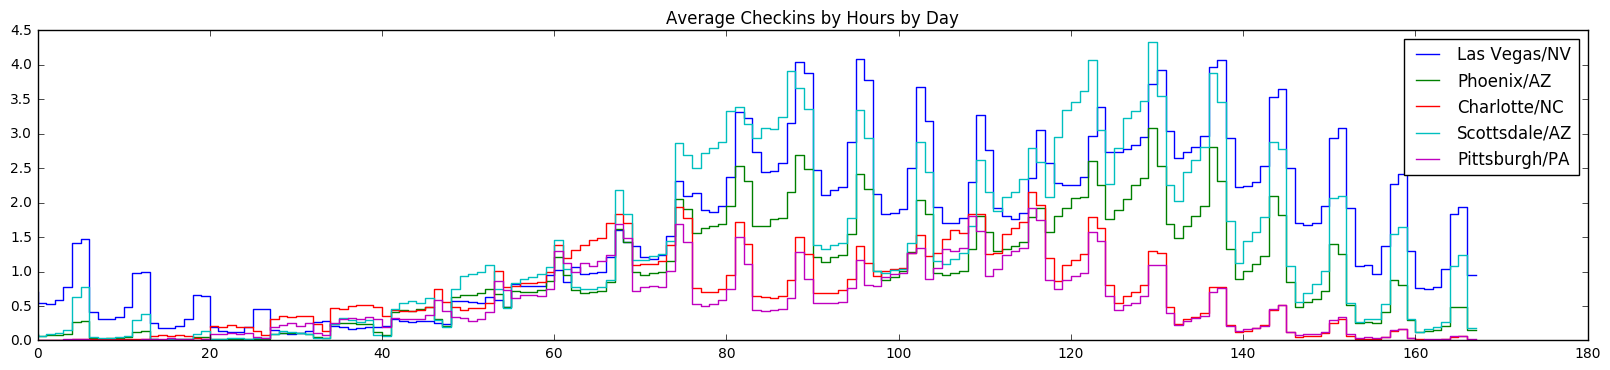

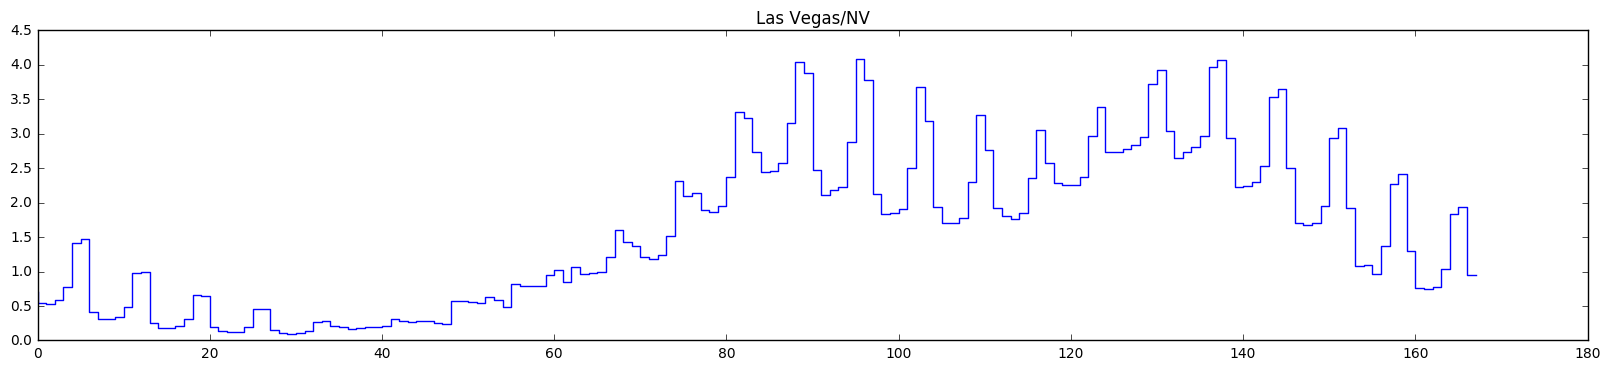

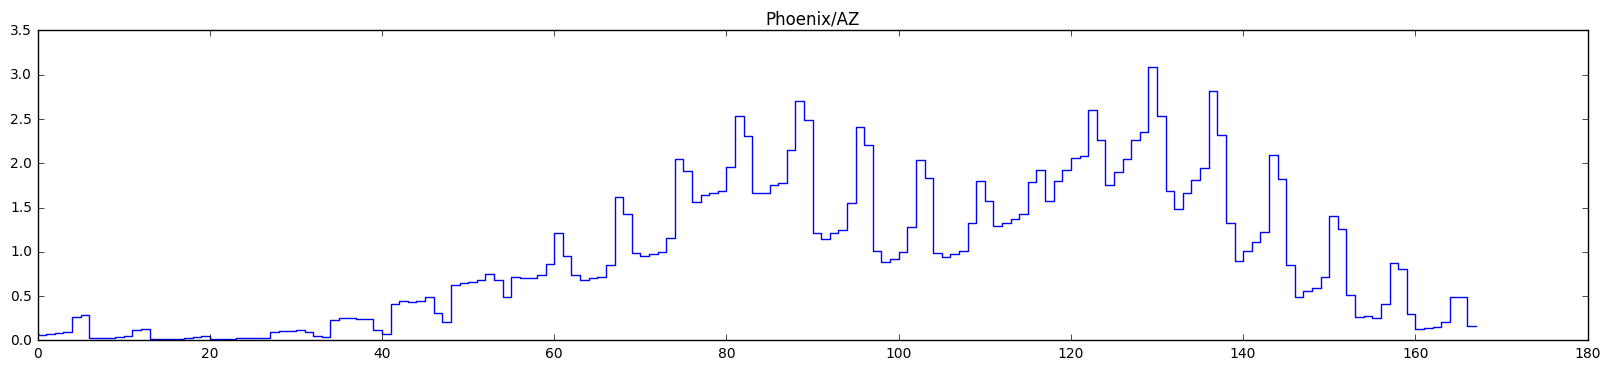

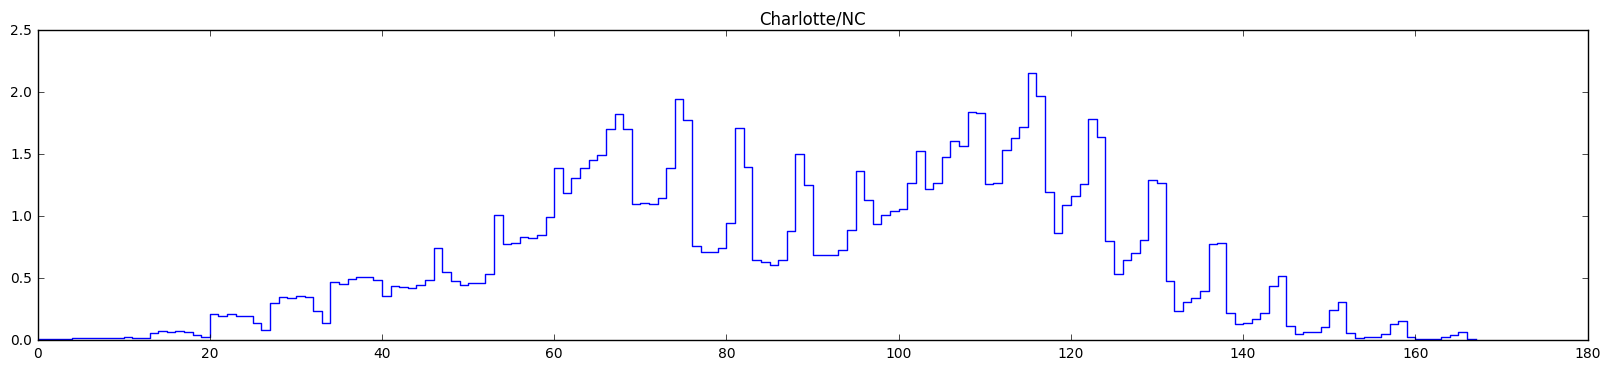

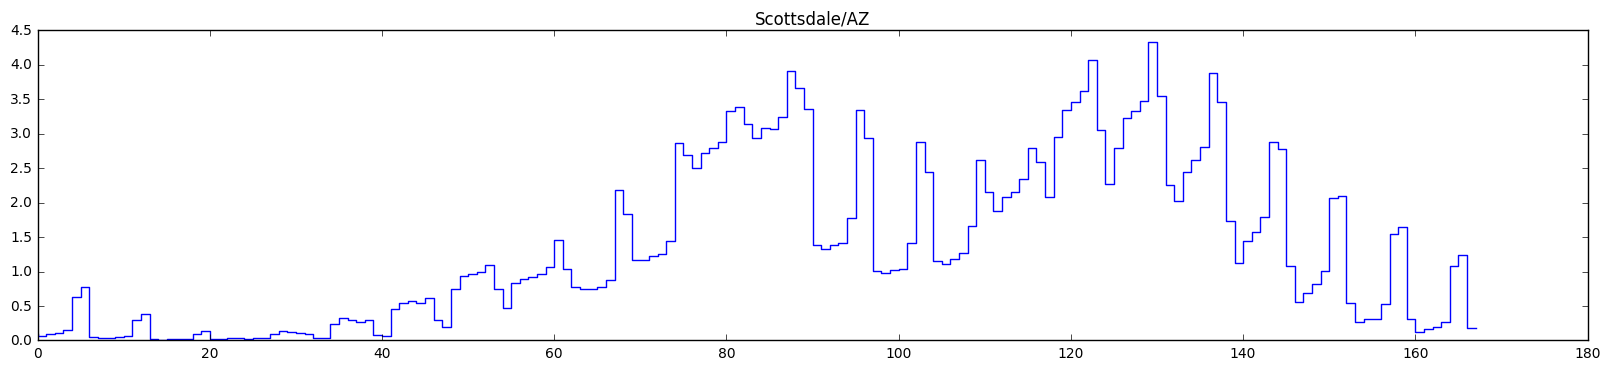

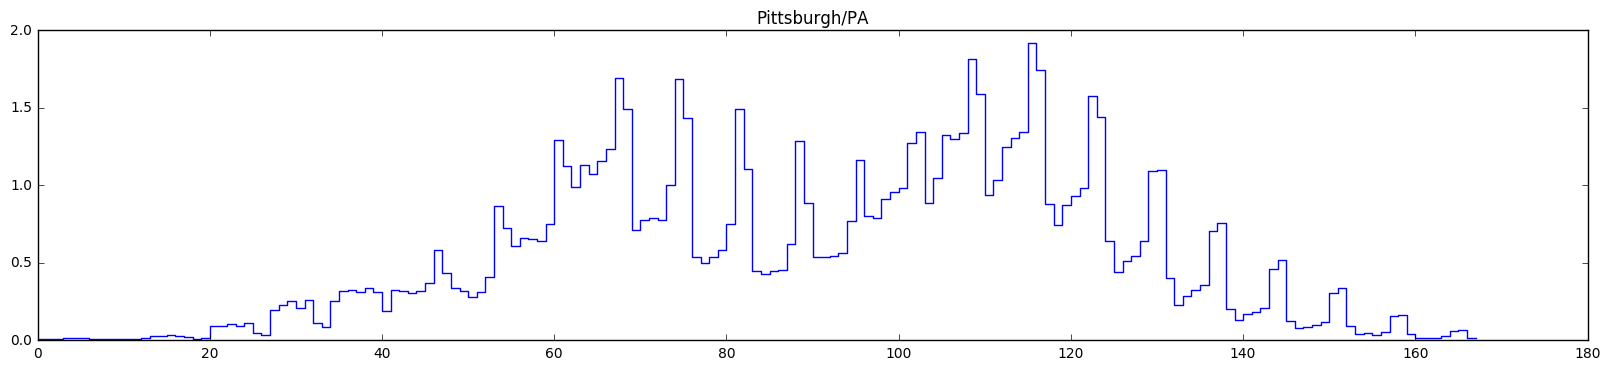

In [268]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
cities = ['Las Vegas/NV', 'Phoenix/AZ', 'Charlotte/NC', 'Scottsdale/AZ', 'Pittsburgh/PA']
for c in cities:
    subdf = df[df.city==c].copy().unstack()
    points = list(subdf.values[1:])    
    plt.step(range(len(points)), points, label=c)
    plt.title("Average Checkins by Hours by Day")
plt.legend()
plt.show()
for c in cities:
    subdf = df[df.city==c].copy().unstack()
    plt.figure(figsize=(20,4))
    points = list(subdf.values[1:])    
    plt.step(range(len(points)), points)
    plt.title(c)
    plt.show()


# Run

2. Write a sentiment analysis script in Python, and use MapReduce to apply to the Yelp reviews. **Run faster:** Produce a table with 'Sentiment' and 'Rating' from Yelp reviews.